# Generating a skewed FC

Following a question on the mailing list about uniformly symmetric simulated functional connectivity, it would be interesting to take a look at generating a more skewed FC.  The question is about the Reduced Wong-Wang model, so let's take a quick look at its phase plane,

In [2]:
%pylab inline
from tvb.simulator.lab import *

Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


To look at the shifts due to coupling, we can do a few simulations,

WARNING  File 'hemispheres' not found in ZIP.


100%|██████████| 2000/2000 [00:00<00:00, 6347.77it/s]


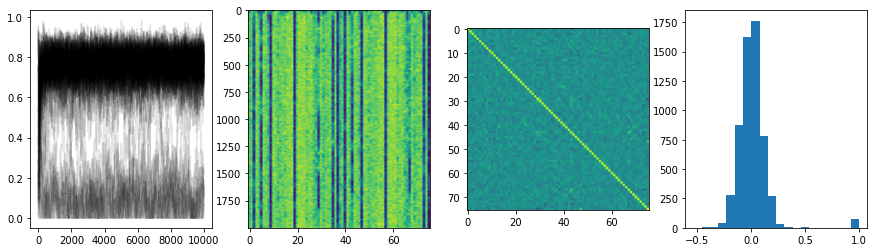

In [126]:
conn76 = connectivity.Connectivity.from_file()
def run(a, I=0.32, sig=1e-5, T=1e3, progress=False):
    rww = models.ReducedWongWang(a=numpy.array([0.27]), w=numpy.array([1.0]), I_o=numpy.array([I]))
    sim = simulator.Simulator(
        model=rww,
        connectivity=conn76,
        coupling=coupling.Linear(a=np.array([a / len(conn76.weights)])),
        integrator=integrators.HeunStochastic(dt=5,
            noise=noise.Additive(nsig=np.array([sig]))), 
        monitors=(monitors.TemporalAverage(period=5.),),
        simulation_length=T
    ).configure()
    (time, data), = sim.run(progress=progress)
    return time, data[:, 0, :, 0]

t, y = run(1.0, sig=0.0001, I=0.28, T=10e3, progress=True)
figure(figsize=(15, 4))
subplot(141); plot(t, y, 'k', alpha=0.1);
subplot(142); imshow(y, aspect='auto')
subplot(143); imshow(np.corrcoef(y[t>(t[-1]/2)].T), vmin=-1, vmax=1)
subplot(144); hist(np.corrcoef(y[t>(t[-1]/2)].T).flat, 20);

Despite varying coupling scaling, excitability shifts, noise strengths (by hand or optimization), the steady state FC is always very close to normally distributed, centered at zero, consistent with the fixed point structure of the model.  Models with intrinsic fluctuations like oscillators can however express fluctuations required to have a shifted or skewed FC:

100%|██████████| 5000/5000 [00:00<00:00, 6893.08it/s]


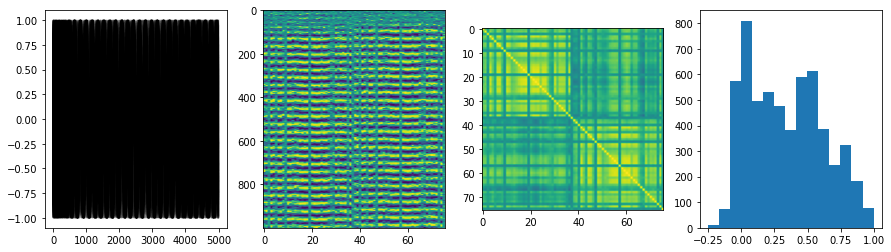

In [210]:
osc = models.Kuramoto(omega=np.r_[0.35])
def run2(a = 0.1, sig = 1e-4, T = 1e3, progress = True):
    sim = simulator.Simulator(
        model=osc,
        connectivity=conn76,
        coupling=coupling.Kuramoto(a=np.array([a / len(conn76.weights)])),
        integrator=integrators.HeunStochastic(dt=1,
            noise=noise.Additive(nsig=np.array([sig]))), 
        monitors=(monitors.TemporalAverage(period=5.),),
        simulation_length=T
    ).configure()
    (time, data), = sim.run(progress=progress)
    return time, data[:, 0, :, 0]


t, y = run2(a=1.5, sig=0.1, T=5e3)
y = np.sin(y)
figure(figsize=(15, 4))
subplot(141); plot(t, y, 'k', alpha=0.1);
subplot(142); imshow(y, aspect='auto')
subplot(143); imshow(np.corrcoef(y[t>(t[-1]/2)].T), vmin=-1, vmax=1)
subplot(144); hist(np.corrcoef(y[t>(t[-1]/2)].T).flat, 15);